In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/usr/local/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
df = pd.read_pickle('hy_data_clean.pkl')

In [4]:
documents = df['Discussion_clean'].to_list()

In [5]:
stoplist = ['the', 'a', 'an', 'of', 'and', 'or', 'in', 'for', 'to', 'at', 'by', 'from', 'with', 'on', 'as', 'but', 'is', 'are', 'was', 'were', 'be', 'been', 'am', 'i', 'me', 'my', 'we', 'our', 'you', 'fish', 'troll', 'ha', 'bye', 'ok', 'okay', 'andy', 'idiot']

# remove common words and tokenize
texts = [[word for word in document.split() if word not in stoplist]
         for document in documents]

In [6]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [7]:
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

In [8]:
# Create the dictionary
dictionary = corpora.Dictionary(texts)

# Filter out words that occur less than X documents, 
# or more than X% of the documents.
dictionary.filter_extremes(no_below=50, no_above=0.5)

# Create the corpus.  This is a Term Frequency 
# or Bag of Words representation.
corpus = [dictionary.doc2bow(text) for text in texts]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 18
Number of documents: 2919


In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [11]:
NUM_TOPICS = 10
chunksize = 2000
passes = 6
iterations = 100
eval_every = 1
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)

2022-03-31 14:46:30,612 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2022-03-31 14:46:30,617 : INFO : using serial LDA version on this node
2022-03-31 14:46:30,619 : INFO : running online (multi-pass) LDA training, 10 topics, 6 passes over the supplied corpus of 2919 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 100x with a convergence threshold of 0.001000
2022-03-31 14:46:30,622 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-03-31 14:46:30,626 : DEBUG : bound: at document #0
2022-03-31 14:46:31,028 : INFO : -4.502 per-word bound, 22.7 perplexity estimate based on a held-out corpus of 2000 documents with 2442 words
2022-03-31 14:46:31,029 : INFO : PROGRESS: pass 0, at document #2000/2919
2022-03-31 14:46:31,029 : DEBUG : performing inference on a chunk of 2000 documents
2022-03-31 14:

In [12]:
def compute_coherence_values(dictionary, corpus, texts, 
                             cohere, limit, start=2, step=2):

    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         random_state=42,)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=cohere)
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [13]:
limit=50
start=2
step=2

In [14]:
coherence_values = compute_coherence_values(dictionary=dictionary, 
                                            corpus=corpus, 
                                            texts=texts, 
                                            cohere='c_v', 
                                            start=start, 
                                            limit=limit, 
                                            step=step)

2022-03-31 14:49:16,699 : INFO : using autotuned alpha, starting with [0.5, 0.5]
2022-03-31 14:49:16,713 : INFO : using serial LDA version on this node
2022-03-31 14:49:16,726 : INFO : running online (multi-pass) LDA training, 2 topics, 6 passes over the supplied corpus of 2919 documents, updating model once every 2000 documents, evaluating perplexity every 2000 documents, iterating 100x with a convergence threshold of 0.001000
2022-03-31 14:49:16,730 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2022-03-31 14:49:16,739 : DEBUG : bound: at document #0
2022-03-31 14:49:17,435 : INFO : -3.523 per-word bound, 11.5 perplexity estimate based on a held-out corpus of 2000 documents with 2442 words
2022-03-31 14:49:17,436 : INFO : PROGRESS: pass 0, at document #2000/2919
2022-03-31 14:49:17,436 : DEBUG : performing inference on a chunk of 2000 documents
2022-03-31 14:49:17,992 : DEBUG : 1941/2000 documents c

2022-03-31 14:54:34,319 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-31 14:54:34,322 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-03-31 14:54:34,325 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2022-03-31 14:54:34,326 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-31 14:54:34,327 : DEBUG : findfont: score(FontEn

2022-03-31 14:54:35,239 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-03-31 14:54:35,241 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-03-31 14:54:35,243 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2022-03-31 14:54:35,245 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-31 14:54:35,247 : DEBUG : findfont: score(FontEn

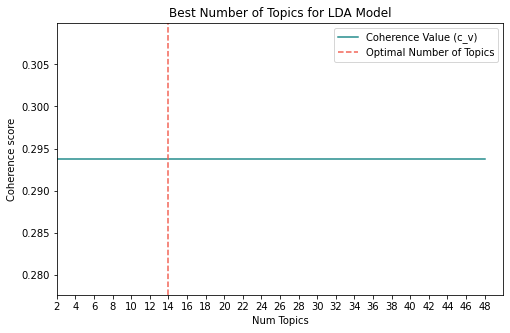

In [15]:
plt.figure(figsize=(8,5))

# Create a custom x-axis
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')

In [16]:
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=100,
    num_topics=14,
    passes=14,
    eval_every=None)

2022-03-31 14:55:52,736 : INFO : using autotuned alpha, starting with [0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575, 0.071428575]
2022-03-31 14:55:52,740 : INFO : using serial LDA version on this node
2022-03-31 14:55:52,743 : INFO : running online (multi-pass) LDA training, 14 topics, 14 passes over the supplied corpus of 2919 documents, updating model once every 2000 documents, evaluating perplexity every 0 documents, iterating 100x with a convergence threshold of 0.001000
2022-03-31 14:55:52,746 : INFO : PROGRESS: pass 0, at document #2000/2919
2022-03-31 14:55:52,747 : DEBUG : performing inference on a chunk of 2000 documents
2022-03-31 14:55:53,039 : DEBUG : 2000/2000 documents converged within 100 iterations
2022-03-31 14:55:53,045 : INFO : optimized alpha [0.06795298, 0.070022024, 0.07344938, 0.070164695, 0.0715918, 0.071491614, 0.06948997, 0.068319224, 0.07

In [17]:
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)

2022-03-31 14:56:40,629 : DEBUG : performing inference on a chunk of 2919 documents
2022-03-31 14:56:40,875 : DEBUG : 2919/2919 documents converged within 100 iterations
/usr/local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the modu